# Predicting Forest Fires in Montesinho National Park (Portugal)
https://www.kaggle.com/datasets/elikplim/forest-fires-data-set

## Introduction

The escalating threat and magnitude of forest fires worldwide have been amplified by climate change. In British Columbia alone in 2018, 1.35 million hectares of forest land burned due to forest fires (Statistics Canada, 2019). These fires cause destruction of wildlife habitats and loss of animal life, the release of toxic gases into the atmosphere, damage to infrastructure, and the potential loss of human health & lives in their aftermath. Acknowledging the potentially catastrophic outcomes of forest fires, it becomes imperative to establish an effective early warning system, enabling agencies to forecast and mitigate these destructive events. 

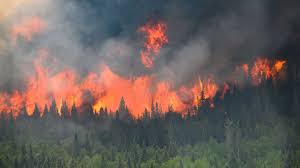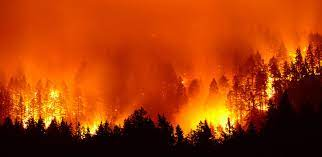
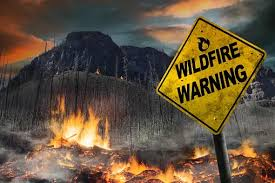 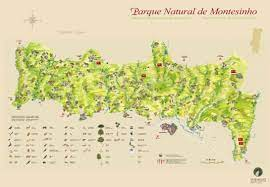


The relevance of this issue motivated us to develop a predictive model to tend to the question; **Can we predict the emergence and severity of a forest fire based on relevant weather metrics? And if we can make these predictions, what model would yield the most accurate predictions?** For this model, what are the weather variables that result in the most accurately predictive model? With that motivation in mind, this project aims to develop and compare a k-nearest neighbours,as well as a multivariate linear model, that can predict the size of a forest fire based on various weather metrics. 

Our data(https://www.kaggle.com/datasets/elikplim/forest-fires-data-set) is from a dataset containing variables related to weather, and data pertaining to fires that occurred for the same period, in Montesinho National Park in Portugal

**The dataset contains 13 columns**: 

**X - x-axis spatial coordinate within the Montesinho park map**: 1 to 9

**Y - y-axis spatial coordinate within the Montesinho park map**: 2 to 9

**month - month of the year**: 'jan' to 'dec'

**day - day of the week**: 'mon' to 'sun'

**FFMC - Fine Fuel Moisture Code index from the FWI system**: 18.7 to 96.20

**DMC - Duff Moisture Code index from the FWI system**: 1.1 to 291.3

**DC - Drought Code index from the FWI system**: 7.9 to 860.6

**ISI - Initial Spread Index from the FWI system**: 0.0 to 56.10

**temp - temperature in Celsius degrees**: 2.2 to 33.30

**RH - relative humidity in %**: 15.0 to 100

**wind - wind speed in km/h**: 0.40 to 9.40

**rain - outside rain in mm/m2**: 0.0 to 6.4

**area - the burned area of the forest (in ha)**: 0.00 to 1090.84


## Methods & Results

To conduct our analysis, we chose to operate with a k-nearest neighbours algorithm regression model rather than a classification model. We chose a regression based model due to the fact that there were not many small - medium sized fires occurring in the dataste, and very few extremely large fires were skewing our results within the classfication model.

To create this model, we planned and executed the following steps:

**Reading & Wrangling**: read and wrangle the dataset into a tidy dataset, also eliminating variables unrelated to metrics, such as location in the park and day/date

**Train/Test split**: spliting the tidy dataframe into a training set and testing set, then summarizing the sample statistics of the training data.

**Predictor variables selection**: find the combination of predictors that yield the relatively highest prediction accuracy, by using forward selection.

**K-Nearest Neighbor Regression**: model tuning with cross-validation, reconfigure and re-train the model with the best K parameter, predict the test set for final model accuracy validation.

**Results and Conclusion**

## Reading in relevant libraries

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
library(ggplot2)
install.packages("kknn")
library(kableExtra)
library(knitr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

### Reading and Tidying of the dataset

In [17]:
url <- "https://raw.githubusercontent.com/perdomopatrick/group7/main/forestfires.csv"
data <- read_csv(url)

clean_data <- data|>
      select(-X,-Y,-month,-day)

clean_data_5 <- head(clean_data, n= 5)

kable_clean_data_5 <- knitr::kable(clean_data_5, "pipe", 
                                 caption = "Forest fires dataset- Cleaned")

Rows: 517 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): month, day
dbl (11): X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, rain, area

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


<div align="center"> Table 1: Forest fires dataset-Cleaned</div>

| FFMC|  DMC|    DC| ISI| temp| RH| wind| rain| area|
|----:|----:|-----:|---:|----:|--:|----:|----:|----:|
| 86.2| 26.2|  94.3| 5.1|  8.2| 51|  6.7|  0.0|    0|
| 90.6| 35.4| 669.1| 6.7| 18.0| 33|  0.9|  0.0|    0|
| 90.6| 43.7| 686.9| 6.7| 14.6| 33|  1.3|  0.0|    0|
| 91.7| 33.3|  77.5| 9.0|  8.3| 97|  4.0|  0.2|    0|
| 89.3| 51.3| 102.2| 9.6| 11.4| 99|  1.8|  0.0|    0|

<div style="text-align: right">output from kable_clean_data in Markdown</div>

### Splitting data into training and test-set.
 Based on our dataset, we have 517 usable datapoints, which we are splitting randomly to the **proportion of 0.75 (75%) to the training set** and **0.25 (25%) to the testing set.**
 
 We used the **set.seed()** function to make code reproducible

In [3]:
set.seed(1133) 

data_split <- initial_split(clean_data, prop = 0.75, strata = area)
data_training <- training(data_split)
data_testing <- testing(data_split)

### Conducting analysis of variables, showing mean values for all variables

In [4]:
mean_stats_train <- data_training|>
    summarise(across(everything(), ~mean(.x, na.rm = TRUE)))|>
    pivot_longer(cols = everything(), 
                 names_to = "Variables", 
                 values_to = "Mean")

# converts tibble to kable
kable_mean_stats_train <- knitr::kable(mean_stats_train, "pipe", 
                                 caption = "Mean of all the variables being analyzed using the values from Figure 1.",
                                label = "Table 2")

<div align="center"> Table 2: Mean of all the variables being analyzed using the values from Figure 1.</div>

|Variables |        Mean|
|:---------|-----------:|
|FFMC      |  90.6772021|
|DMC       | 109.9064767|
|DC        | 541.4875648|
|ISI       |   9.0487047|
|temp      |  18.9655440|
|RH        |  44.1502591|
|wind      |   4.0261658|
|rain      |   0.0253886|
|area      |  14.1083161|

<div style="text-align: right">output from kable_mean_stats_train in Markdown</div>

### Predictor Variable Selection Analysis through applying the Forward Selection Method

Forward Selection allows for us to systematically choose the best combination of predictor variables for our regression model by adding them one by one based on how much they improve the model's accuracy on our training set. This way, we aim to create the most accurate model with the fewest necessary variables.


In [5]:
set.seed(1133) 

names <- colnames(data_training |> select(-area))

results <- tibble(size = integer(), 
                     model_string = character(), 
                     RMSE = numeric())

# create a model specification for regression KNN
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

# create a 5-fold cross-validation object
fire_vfold <- vfold_cv(data_training, v = 5, strata = area)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
  # for every predictor still not added yet
  rmses <- list()
  models <- list()
  for (j in 1:length(names)) {
    # create a model string for this combination of predictors
    preds_new <- c(selected, names[[j]])
    model_string <- paste("area", "~", paste(preds_new, collapse="+"))

    # create a recipe from the model string
    fire_recipe <- recipe(as.formula(model_string), 
                            data = data_training) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

    # tune the KNN regressor with these predictors, 
    # and collect the RMSE for the best K
    rmse <- workflow() |>
      add_recipe(fire_recipe) |>
      add_model(knn_spec) |>
      tune_grid(resamples = fire_vfold, grid = 10) |>
      collect_metrics() |>
      filter(.metric == "rmse") |>
      summarize(mx = min(mean))
    rmse <- rmse$mx |> unlist()

    # add this result to the dataframe
    rmses[[j]] <- rmse
    models[[j]] <- model_string
  }
  jstar <- which.min(unlist(rmses))
  results <- results |> 
    add_row(size = i, 
            model_string = models[[jstar]], 
            RMSE = rmses[[jstar]])
  selected <- c(selected, names[[jstar]])
  names <- names[-jstar]
}

# converts tibble to kable
kable_results <- knitr::kable(results, "pipe", 
                                 caption = "Result of forward selection, displaying the accuracy of the variables added by the forward selection procedure.",
                                label = "Table 3")

! Fold1: internal:
  There were 10 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(truth = area,...
    na_rm)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! A correlation computation is required, but `estimate` is c...
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 9 r...

! Fold2: internal:
  There were 10 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(truth = area,...
    na_rm)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! A correlation computation is required, but `estimate` is c...
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 9 r...

! Fold3: internal:
  There were 10 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(truth = area,...
    na_rm)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! A correlation computation is required, but `estimate` is c...
  ℹ Run `dplyr::last_dplyr_warni

<div align="center"> Table 3: Result of forward selection, displaying the accuracy of the variables added by the forward selection procedure. </div>

| size|model_string                             |     RMSE|
|----:|:----------------------------------------|--------:|
|    1|area ~ RH                                | 60.67079|
|    2|area ~ RH+rain                           | 60.69569|
|    3|area ~ RH+rain+DMC                       | 64.84574|
|    4|area ~ RH+rain+DMC+wind                  | 64.64394|
|    5|area ~ RH+rain+DMC+wind+ISI              | 63.80702|
|    6|area ~ RH+rain+DMC+wind+ISI+DC           | 64.38295|
|    7|area ~ RH+rain+DMC+wind+ISI+DC+FFMC      | 64.91035|
|    8|area ~ RH+rain+DMC+wind+ISI+DC+FFMC+temp | 66.77548|

<div style="text-align: right">output from kable_results in Markdown</div>

Table 3 shows the results of **FSM** analysis for all the variables, and the corresponding value of **RMSE (Root Mean Squared Error)** for the model containing those variables. Due to the nature of the values in the dataset, the **lowest RMSE value was happening to coincide with the model containing only the variable "RH"(Relative Humidity)**. However a model based off of only **one variable is not likely to be a good predictor**, so we chose a combination containing a balance of number of variables and a low RMSE.     

As meaningful predictors are added, the estimated accuracy increases substantially; whereas adding irrelevant variables causes the accuracy to either exhibit small fluctuations or decrease as the model attempts to tune the number of neighbours to account for the extra noise.

We found this balance in **combination 5**, containing 5 variables,**RH+rain+DMC+wind+ISI.**

### Visualizing the distributions of the variables included in Combination 5 (Forward Selected)


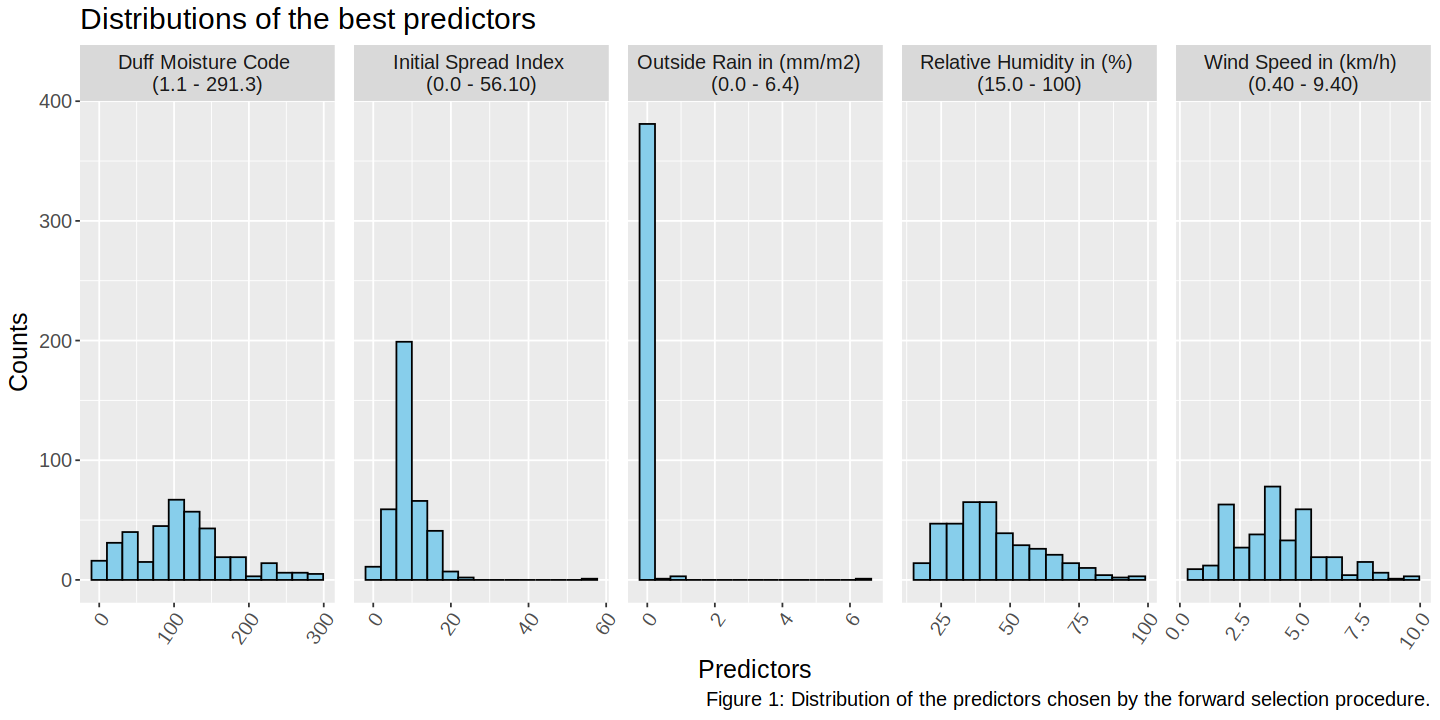

In [6]:
options(repr.plot.width = 12, repr.plot.height = 6)

melted_data <- data_training |>
    select(-FFMC, -DC, -temp) |> 
    pivot_longer(cols = -area,
                 names_to = "predictors",
                 values_to = "values")

predictor_labels <- c(RH = "Relative Humidity in (%) \n(15.0 - 100)",
                   rain = "Outside Rain in (mm/m2)  \n(0.0 - 6.4)",
                     DMC="Duff Moisture Code \n(1.1 - 291.3)",
                     wind="Wind Speed in (km/h) \n(0.40 - 9.40)",
                     ISI="Initial Spread Index \n(0.0 - 56.10)")

distribution_plot <- melted_data |>
    ggplot(aes(x = values)) + 
    geom_histogram(position = 'identity', bins = 15, fill = "skyblue", color = "black") +
    labs(x = "Predictors",
         y = "Counts",
         title = "Distributions of the best predictors",
         caption = "Figure 1: Distribution of the predictors chosen by the forward selection procedure.") +
    facet_grid(cols = vars(predictors), scales = "free",
               labeller = labeller(predictors = predictor_labels)) +
    theme(text = element_text(size = 15), 
          axis.text.x = element_text(angle = 55, hjust=1),
         panel.spacing = unit(0.8, "lines"))
distribution_plot

### Analysis of the predictors' distributions

Figure 1 shows the distribution of each of the selected variables. The **DMC- Duff Moisture Code** variable seems to be roughly normally distributed about a mean value, as well as **ISI- Initial Spread Index** and **Wind- Wind Speed**. The other variables seem to be **right-skewed** with **Rain** being extremely right skewed and **RH- Relative Humidity** still being right skewed, but to a lesser extent.

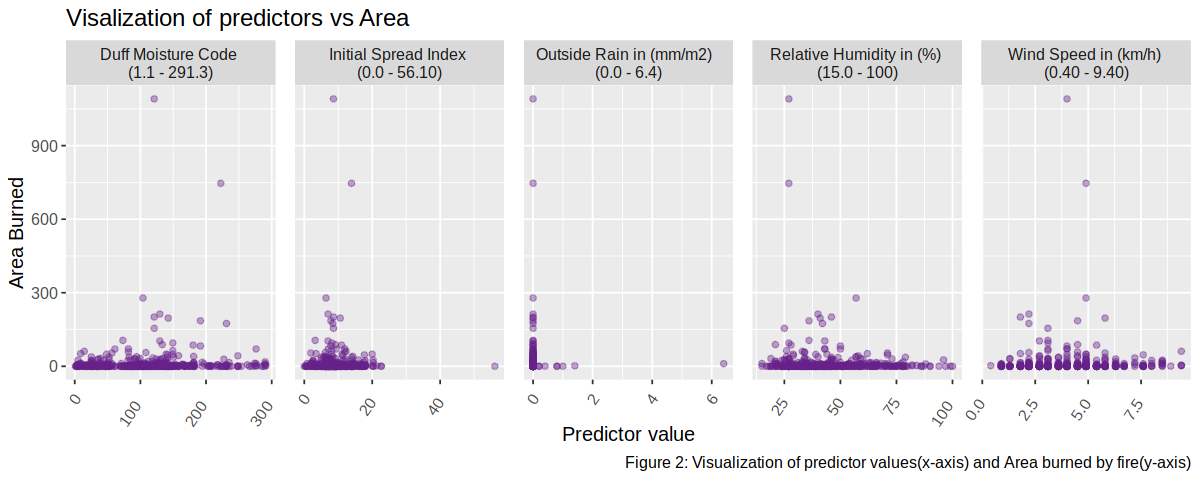

In [13]:
# all the data without the irrelevant columns pivoted longer to be used by facet_grid()
long_data <- data |>
    select(-X, -Y, -month, -day, -FFMC, -DC, -temp) |> 
    pivot_longer(cols = -area,
                 names_to = "predictors",
                 values_to = "values")

options(repr.plot.width = 10, repr.plot.height = 4)

# Initial graph before predictions
initial_plot <- ggplot(long_data, aes(x = values, y = area)) +
  geom_point(alpha = 0.4, color = "darkorchid4") +
  xlab("Predictor value") +
  ylab("Area Burned") +
 facet_grid(cols = vars(predictors), scales = "free",
               labeller = labeller(predictors = predictor_labels)) +
  ggtitle(paste0("Visalization of predictors vs Area")) + 
  theme(text = element_text(size = 12), 
        axis.text.x = element_text(angle = 55, hjust=1.5),
       panel.spacing = unit(0.8, "lines")) +
  labs(caption = "Figure 2: Visualization of predictor values(x-axis) and Area burned by fire(y-axis)")


initial_plot

Figure 2 above, shows the values of each of the predictors' values, corresponding to the same dates as fires occurred, and allows us to examine individual relationships between the predictors and how they contribute to a forest fire's size.

**DMC** as well as **Wind speed**, seem to have a **very weak but present, positive correlation with fire size**. This data weakly is suggesting that higher wind speeds could be blowing fires further causing them to spread, paired with high DMC values(indicative of drier conditions).

The other variables of interest seem to be weakly related, however, it would not be a completely valid conclusion to draw. This is due to our data being very specific to a location, and may be differently related across other regions - the scope of our data is too narrow to make generalizations about forest fires in a wider sense.

### Tuning of the K-NN Regression Model

In [18]:
set.seed(1133) 

# recipe with all predictors
fire_recipe <- recipe(area ~ RH + rain + DMC + wind + ISI, data = data_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# model for tuning
fire_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                  set_engine("kknn") |>
                  set_mode("regression")

fire_vfold <- vfold_cv(data_training, v = 5, strata = area)

# creates workflow from recipe + model
fire_wkflw <- workflow() |>
  add_recipe(fire_recipe) |>
  add_model(fire_spec)

gridvals <- tibble(neighbors = seq(1, 200))

# Filters for rmse
fire_results <- fire_wkflw |>
  tune_grid(resamples = fire_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse") |>
  select(-std_err,-.config)



fire_results_5 <- head(fire_results, n= 5)

# converts tibble to kable
kable_fire_results_5 <- knitr::kable(fire_results_5, "pipe", 
                                 caption = "Shows the RMSE (mean) for all of the neighbours values (neighbors).",
                                label = "Table 4")

<div align="center"> Table 4: Shows the RMSE (mean) for 5 of the neighbours values (neighbors).</div>

| neighbors|.metric |.estimator |     mean|  n|
|---------:|:-------|:----------|--------:|--:|
|         1|rmse    |standard   | 79.83670|  5|
|         2|rmse    |standard   | 80.88126|  5|
|         3|rmse    |standard   | 74.79210|  5|
|         4|rmse    |standard   | 71.53269|  5|
|         5|rmse    |standard   | 66.91379|  5|

We now conduct the K-NN regression analysis on our dataset with predictors: RH, wind DMC, ISI, Rain.
To do this, we:

**Define a recipe with the predictors:** RH, wind, DMC, ISI, Rain- to further scale and center our predictors.

**Define the specification for our k-nn model:** We use tune() for the neighbours argument because we will first tune our model to choose the best k-value for our model.

**Perform cross-validation with 5 folds.:** This is because our dataset is not too large so 20% of the data for validation is sufficiently accurate.

**Create a workflow** adding the recipe and the model and applying the tune_grid() function for cross-validation. We then collect the resulting accuracies with the collect_metrics() function.

Finally, **we plot the accuracies against the neighbours** in order to visualize the most stable k nearest neighbour.
Figure 3 below demonstrates that k = 30 is the most optimal value. This is because it is about roughly where the curve begins to level off.

In [24]:
# Gets mean
fire_min <- fire_results |>
  filter(mean == min(mean))

fire_optimal <- fire_results |>
    filter(neighbors == 30)

# converts tibble to kable
kable_fire_min <- knitr::kable(fire_min, "pipe", 
                                 caption = "Shows the neighbour value (neighbors) with the lowest RMSE (mean)",
                                label = "Table 5")
# converts tibble to kable
kable_fire_optimal <- knitr::kable(fire_optimal, "pipe", 
                                 caption = "Shows the neighbour value (neighbors) with the lowest RMSE (mean)",
                                label = "Table 6")

<div align="center"> Table 5: Shows the neighbor value (neighbors) with the lowest RMSE (mean) </div>

| neighbors|.metric |.estimator |     mean|  n|
|---------:|:-------|:----------|--------:|--:|
|       200|rmse    |standard   | 51.45783|  5|

<div style="text-align: right">output from kable_fire_min in Markdown</div>

<div align="center"> Table 6: Shows the neighbor value (neighbors) with the most optimal value RMSE (mean) </div>

| neighbors|.metric |.estimator |     mean|  n|
|---------:|:-------|:----------|--------:|--:|
|        30|rmse    |standard   | 53.08259|  5|

<div style="text-align: right">output from kable_fire_optimal in Markdown</div>

We chose to check the k-neighbor values from 1 to 200 as it covers most of the possible k-neighbour values and the impact of the changing k-neighbors on the RMSE decreases the larger the range.

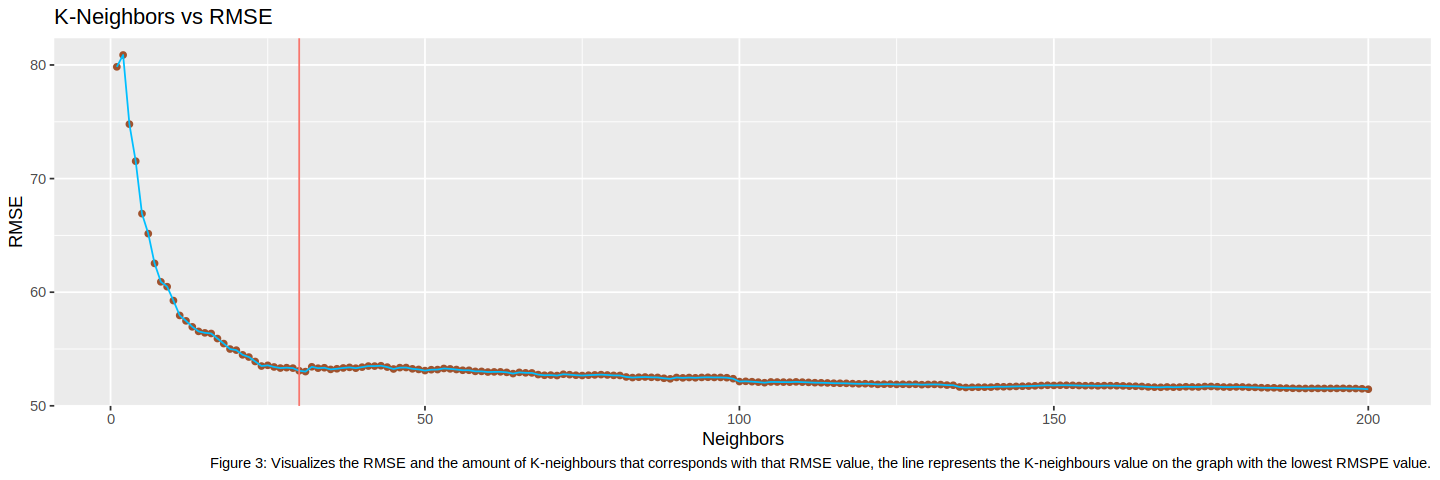

In [19]:
options(repr.plot.width = 12, repr.plot.height = 4)

# Visualization of best neighbors
fire_neighbors <- fire_results |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_point(colour = "sienna") +
  geom_line(colour = "deepskyblue") +
  geom_vline(aes(xintercept = 30, colour = "red")) + # the number of neighbors that will be used
  labs(x = "Neighbors", 
       y = "RMSE", 
       caption = "Figure 3: Visualizes the RMSE and the amount of K-neighbours that corresponds with that RMSE value, the line represents the K-neighbours value on the graph with the lowest RMSPE value.", 
       title ="K-Neighbors vs RMSE") +
  theme(legend.position="none")

fire_neighbors

With a decided k value for neighbours **n=30**, we can continue with K-NN regression. for this we use a workflow created with the **training data** to get a new rmse estimate and predict using the **testing set**

### KNN-Regression 



In [25]:
# create model
new_fire_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 30) |>
  set_engine("kknn") |>
  set_mode("regression")

# create workflow
new_fire_fit <- workflow() |>
  add_recipe(fire_recipe) |>
  add_model(new_fire_spec) |>
  fit(data = data_training)

# gets new rmse estimate
new_fire_results <- new_fire_fit |>
  predict(data_testing) |>
  bind_cols(data_testing) |>
  metrics(truth = area, estimate = .pred) |>
  filter(.metric == 'rmse')

kable_new_fire_results <- knitr::kable(new_fire_results, "pipe", 
                                 caption = "RMSPE value as determined by the lowest k-neighbours value",
                                label = "Table 7")

<div align="center"> Table 7: RMSPE value as determined by the lowest k-neighbours value (n=30) </div>

|.metric |.estimator | .estimate|
|:-------|:----------|---------:|
|rmse    |standard   |  27.32208|

<div style="text-align: right">output from kable_new_fire_results in Markdown</div>

The model we created using k-nn regression predicted an rmse value of 27.3. This could be a relatively low figure given the limited nature of our dataset. I t would be better if we had another similar model to compare it to.

### Linear-Regression


Here, we conducted the same regression, using a linear instead of KNN model for the regression; to have a point of reference to compare to. 

In order for results to be comparable, we used the same variables selected by forward selection, used for the knn model too.

In [26]:
## Create the model specification for linear regression
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

## Use workflow() to fit/build the model on the training data
lm_fit <- workflow() |>
  add_recipe(fire_recipe) |>
  add_model(lm_spec) |>
  fit(data = data_training)

## Make predictions on the test data and evaluate the accuracy
lm_test_results <- lm_fit |>
  predict(data_testing) |>
  bind_cols(data_testing) |>
  metrics(truth = area, estimate = .pred)

# RMSPE value.
rmse <- lm_test_results |>
    filter(.metric == "rmse")

kable_lm_fire_results <- knitr::kable(lm_test_results, "pipe",
                                      caption = "RMSPE value as determined by the multivariate linear model",
                                      label = "Table 8")

<div align="center"> Table 7: RMPSE value as determined by the multivariate linear model </div>

|.metric |.estimator | .estimate|
|:-------|:----------|---------:|
|rmse    |standard   |  27.1533|

<div style="text-align: right">output from kable_new_fire_results in Markdown</div>

The linear model has got a marginally lower rmse value of 27.15 than the knn model, indicating this dataset, with these variables is better predicted under a linear model.

## Comparison of the Linear vs KNN regression models

KNN Regression provides a RMSE on the test data of 27.3 and linear regression provides a RMSE of 27.15. Therefore linear  regression proves to be a better method for predicting the fire affected area on the set of predictor variables. This is likely because linear is better for data sets with fewer data points. Overall linear regression is the preferred method for predicting burned area for the Montesinho National Park fires data.

## Discussion

From our **analysis with this particular dataset**, we found that the best variables to predict forest fire size are Relative humidity, Amount of rainfall, Duff moisture code, wind speed and Initial Spread Index; this was done by **forward selection**. These variables do make logical sense to be determinant of fire size, as each of them **reflects an aspect of environmental conditions that affect how quickly a fire can grow**.

It was a surprise however, that **FFMC- Fine fuel moisture code** was not a variable of particular interest to the model.  Fine Fuel Moisture Code is a metric derived from a combination of variables ranging from historical measurement of temperature, humidity, wind speed, and 24-hour precipitation (Amiro, Logan, Wotton, et al., 2005). This led us to believe that FFMC would be a significant variable in predicting a forest fire's size.  

From our analysis of all the given variables in the dataset, we carefully examined how each of the variables correlates with one another. However it would be better for our model if we were able to have greater data available, not just for one year and one location. Through our analysis we hope to better equip the Portuguese Park Protection authorities. We also hope the authorities are able to clamp down on the number of forest fires, damages to human lives, infrastructure, and the environment due to the variables mentioned.

Some further research could be done into the following related topics:

Can our model be implemented if presented with an observation from another climates? 

As our data is very limited to a particular location, how can we adjust our model accordingly to different regions in the world? Will there be more predictor values in other datasets? Should we input a KNN regression opposed to our preferred linear regression if this is the case?

With rapid climate changes and increasing frequency of forest fires, how can we as data scientists stay ahead of the variables? How will these variables of interest change as the earth's climate changes?

How can we combine our analysis with the metrics being used in the real world to develop a more efficient and reliable forest fire prevention system?


## References

Flannigan, M. D., Logan, K. A., Amiro, B. D., Skinner, W. R., &amp; Stocks, B. J. (2005). Future area burned in Canada. Climatic Change, 72(1–2), 1–16. https://doi.org/10.1007/s10584-005-5935-y 

Darlington, A. (2017, September 4). Forest fires data set. Kaggle. https://www.kaggle.com/datasets/elikplim/forest-fires-data-set 

Public accounts of canada - public accounts of canada 2019. Open Government Portal. (2019). https://open.canada.ca/data/en/dataset/350b4f13-d84a-4e94-b221-1109dc00ab39/resource/ddfafc53-cca6-46c1-8780-cfa94fd1382b 